#### Setup

In [ ]:
! pip install transformers

In [ ]:
# Install Kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

In [4]:
import contextlib
from google.colab import files
import io

with contextlib.redirect_stdout(io.StringIO()):
    files.upload()

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c AI4Code

!  unzip /content/AI4Code.zip -d /content/data

! rm -rf /content/AI4Code.zip

### Imports and Globals

In [34]:
import json
from pathlib import Path
import os
import numpy as np
import pandas as pd
from scipy import sparse
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

pd.options.display.width = 180
pd.options.display.max_colwidth = 120

BERT_PATH = Path('/content/distil_bert_uncased')

os.makedirs(BERT_PATH, exist_ok=True)

data_dir = Path('/content/data')

### Read input data

In [7]:
NUM_TRAIN = 10000


def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem)
        .rename_axis('cell_id')
    )


paths_train = list((data_dir / 'train').glob('*.json'))[:NUM_TRAIN]
notebooks_train = [
    read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')
]
df = (
    pd.concat(notebooks_train)
    .set_index('id', append=True)
    .swaplevel()
    .sort_index(level='id', sort_remaining=False)
)

df

Train NBs: 100%|██████████| 10000/10000 [00:42<00:00, 238.05it/s]


cell_type                                                                                                                   source
id             cell_id                                                                                                                                    
000e671b3324e2 f73deb11      code  import os\nfrom logging import getLogger, INFO, StreamHandler, FileHandler, Formatter\nfrom functools import partial...
               59a1849b      code  def get_logger(filename='log'):\n    logger = getLogger(__name__)\n    logger.setLevel(INFO)\n    handler1 = StreamH...
               66d043a9      code           OUTPUT_DICT = './'\n\nID = 'Patient_Week'\nTARGET = 'FVC'\nSEED = 37\nseed_everything(seed=SEED)\n\nN_FOLD = 5
               881ea985      code  train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')\ntrain[ID] = train['Patient'].astype(s...
               17857a56      code  # construct train input\n\noutput = pd.DataFrame()\ngb = train.groupby('Patient')\ntk0 = tqdm(gb, total=len(gb))\nfo...
...                           ...                                                                                                                      ...
fff409a8b2ee3a c503776d  markdown  * **Box and Whisker Plots****\n\nBox and Whisker plots, also called boxplots in short, is another useful technique t...
               3590f5dc  markdown  **if you write (((from pandas.tools.plotting import scatter_matrix))) you will get an error. **\n\n\n\n*the answer i...
               1e1b2f33  markdown                  What is Data Visualization?\nThere's a story behind your numbers. Visualizing data brings them to life.
               f21c639f  markdown  * ****Density Plots**\n\nAnother quick and easy technique for getting each attributes distribution is Density plots....
               f0126566  markdown  **The dataset :**\n\n\n* **Context**\nThis dataset is originally from the National Institute of Diabetes and Digesti...

[459958 rows x 2 columns]

Let's analyse an example notebook.

* df created above contains all the commands (disordered)
* Order df (train_orders.csv) contains the order of the cells in the notebooks

In [8]:
nb_id = df.index.unique('id')[6]
print('Notebook:', nb_id)

print("The disordered notebook:")
nb = df.loc[nb_id, :]
display(nb)
print()

Notebook: 00375d945c66b2
The disordered notebook:


,cell_type,source
cell_id,,
6ed7f115,code,"# importing the package needed\nfrom __future__ import unicode_literals, print_function\nfrom pathlib import Path\nf..."
f1e20a7f,code,"df_train = pd.read_csv(""../input/scl-2021-ds/train.csv"")\n \n# split POI and street\ndf_train['poi'] = df_train['POI..."
b1e6b951,code,# change to the SpaCy train data format\nTRAIN_DATA = []\nfor i in range(len(df_train)):\n if (df_train['poi'].va...
b0786a95,code,"# train using GPU\nspacy.prefer_gpu()\n\n# make a empty model\nnlp = spacy.blank(""id"")\n\n# create ner for the model..."
f8bfb8b7,code,"# number of iteration for training\nn_iter = 40\n\n# add all the label (POI, STREET) to the ner\nfor _, annotations ..."
4a0c19de,code,# save the model to use next time\noutput_dir = Path('./')\nnlp.to_disk(output_dir)
40633d34,code,# to load the saved model\noutput_dir = Path('../input/spacy-training-from-scratch')\nnlp = spacy.load(output_dir)
1fa70657,code,"df_test = pd.read_csv(""../input/scl-2021-ds/test.csv"")\ndf_test"
86fac0e3,code,# predict using test data\nresult = []\nfor i in range(len(df_test)):\n # each test data is predicted\n poi = ...


In [9]:
df_orders = pd.read_csv(
    data_dir / 'train_orders.csv',
    index_col='id',
    squeeze=True,
).str.split()  # Split the string representation of cell_ids into a list

df_orders

id
00001756c60be8    [1862f0a6, 448eb224, 2a9e43d6, 7e2f170a, 038b763d, 77e56113, 2eefe0ef, 1ae087ab, 0beab1cd, 8ffe0b25, 9a78ab76, 0d136...
00015c83e2717b    [2e94bd7a, 3e99dee9, b5e286ea, da4f7550, c417225b, 51e3cd89, 2600b4eb, 75b65993, cf195f8b, 25699d02, 72b3201a, f2c75...
0001bdd4021779    [3fdc37be, 073782ca, 8ea7263c, 80543cd8, 38310c80, 073e27e5, 015d52a4, ad7679ef, 7fde4f04, 07c52510, 0a1a7a39, 0bcd3...
0001daf4c2c76d    [97266564, a898e555, 86605076, 76cc2642, ef279279, df6c939f, 2476da96, 00f87d0a, ae93e8e6, 58aadb1d, d20b0094, 986fd...
0002115f48f982                                 [9ec225f0, 18281c6c, e3b6b115, 4a044c54, 365fe576, a3188e54, b3f6e12d, ee7655ca, 84125b7a]
                                                                           ...                                                           
fffc30d5a0bc46    [09727c0c, ff1ea6a0, ddfef603, a01ce9b3, 3ba953ee, bf92a015, f4a0492a, 095812e6, 53125cfe, aa32a700, 63340e73, 06d8c...
fffc3b44869198    [978a5137, fa

In [10]:
len(df_orders.loc[nb_id])

20

In [11]:
cell_order = df_orders.loc[nb_id]

print("The ordered notebook:")
nb.loc[cell_order, :]

The ordered notebook:


,cell_type,source
cell_id,,
692fba8d,markdown,# Setup env
6ed7f115,code,"# importing the package needed\nfrom __future__ import unicode_literals, print_function\nfrom pathlib import Path\nf..."
921a74c1,markdown,"# Prepare Train Data\nWe first seperate the `'POI/street'` column using `.split()`\n\nThen, we find the start index ..."
f1e20a7f,code,"df_train = pd.read_csv(""../input/scl-2021-ds/train.csv"")\n \n# split POI and street\ndf_train['poi'] = df_train['POI..."
3bb6e158,markdown,"The format of the SpaCy `TRAIN_DATA` what we wanted is \n\n`('<train data>',{'entities': [(<start index>, <end index..."
b1e6b951,code,# change to the SpaCy train data format\nTRAIN_DATA = []\nfor i in range(len(df_train)):\n if (df_train['poi'].va...
0f1486e8,markdown,# Train SpaCy model
5b66e91a,markdown,This is the part where I reference from https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/ ...
b0786a95,code,"# train using GPU\nspacy.prefer_gpu()\n\n# make a empty model\nnlp = spacy.blank(""id"")\n\n# create ner for the model..."


Add rank to the cells in train_orders df

In [12]:
def get_ranks(base, derived):
    return [base.index(d) for d in derived]

# testing the function on the above example train_order sample
cell_ranks = get_ranks(cell_order, list(nb.index))
nb.insert(0, 'rank', cell_ranks)

nb

,rank,cell_type,source
cell_id,,,
6ed7f115,1,code,"# importing the package needed\nfrom __future__ import unicode_literals, print_function\nfrom pathlib import Path\nf..."
f1e20a7f,3,code,"df_train = pd.read_csv(""../input/scl-2021-ds/train.csv"")\n \n# split POI and street\ndf_train['poi'] = df_train['POI..."
b1e6b951,5,code,# change to the SpaCy train data format\nTRAIN_DATA = []\nfor i in range(len(df_train)):\n if (df_train['poi'].va...
b0786a95,8,code,"# train using GPU\nspacy.prefer_gpu()\n\n# make a empty model\nnlp = spacy.blank(""id"")\n\n# create ner for the model..."
f8bfb8b7,10,code,"# number of iteration for training\nn_iter = 40\n\n# add all the label (POI, STREET) to the ner\nfor _, annotations ..."
4a0c19de,11,code,# save the model to use next time\noutput_dir = Path('./')\nnlp.to_disk(output_dir)
40633d34,12,code,# to load the saved model\noutput_dir = Path('../input/spacy-training-from-scratch')\nnlp = spacy.load(output_dir)
1fa70657,14,code,"df_test = pd.read_csv(""../input/scl-2021-ds/test.csv"")\ndf_test"
86fac0e3,15,code,# predict using test data\nresult = []\nfor i in range(len(df_test)):\n # each test data is predicted\n poi = ...


Assign correct cell order rank in the df created from raw data

In [13]:
# Step 1 : Add correct cell order to df, using order in df_orders 
df_orders_ = df_orders.to_frame().join(
    df.reset_index('cell_id').groupby('id')['cell_id'].apply(list),
    how='right',
)

# Step 2 - Get rank (here cell_order is base and cell_id retreived from df_orders is the derived)
ranks = {}
for id_, cell_order, cell_id in df_orders_.itertuples():
    ranks[id_] = {'cell_id': cell_id, 'rank': get_ranks(cell_order, cell_id)}

# Step 3 - Create a dataframe out of it
df_ranks = (
    pd.DataFrame
    .from_dict(ranks, orient='index')
    .rename_axis('id')
    .apply(pd.Series.explode)
    .set_index('cell_id', append=True)
)

df_ranks

rank
id             cell_id      
000e671b3324e2 f73deb11    1
               59a1849b    3
               66d043a9    5
               881ea985    7
               17857a56    8
...                      ...
fff409a8b2ee3a c503776d   10
               3590f5dc   15
               1e1b2f33    0
               f21c639f    7
               f0126566    1

[459958 rows x 1 columns]

Read in ancestors data

In [14]:
df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
df_ancestors

,ancestor_id,parent_id
id,,
00001756c60be8,945aea18,NaN
00015c83e2717b,aa2da37e,317b65d12af9df
0001bdd4021779,a7711fde,NaN
0001daf4c2c76d,090152ca,NaN
0002115f48f982,272b483a,NaN
...,...,...
fffc30d5a0bc46,6aed207b,NaN
fffc3b44869198,a6aaa8d7,NaN
fffc63ff750064,0a1b5b65,NaN


Merge ranks and ancestors to raw data

In [15]:
df = df.reset_index().merge(df_ranks, on=["id", "cell_id"]).merge(df_ancestors, on=["id"])
df

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id
0,000e671b3324e2,f73deb11,code,"import os\nfrom logging import getLogger, INFO, StreamHandler, FileHandler, Formatter\nfrom functools import partial...",1,db27dfa2,017b79ae175b2a
1,000e671b3324e2,59a1849b,code,def get_logger(filename='log'):\n logger = getLogger(__name__)\n logger.setLevel(INFO)\n handler1 = StreamH...,3,db27dfa2,017b79ae175b2a
2,000e671b3324e2,66d043a9,code,OUTPUT_DICT = './'\n\nID = 'Patient_Week'\nTARGET = 'FVC'\nSEED = 37\nseed_everything(seed=SEED)\n\nN_FOLD = 5,5,db27dfa2,017b79ae175b2a
3,000e671b3324e2,881ea985,code,train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')\ntrain[ID] = train['Patient'].astype(s...,7,db27dfa2,017b79ae175b2a
4,000e671b3324e2,17857a56,code,"# construct train input\n\noutput = pd.DataFrame()\ngb = train.groupby('Patient')\ntk0 = tqdm(gb, total=len(gb))\nfo...",8,db27dfa2,017b79ae175b2a
...,...,...,...,...,...,...,...
459953,fff409a8b2ee3a,c503776d,markdown,"* **Box and Whisker Plots****\n\nBox and Whisker plots, also called boxplots in short, is another useful technique t...",10,c87a8169,NaN
459954,fff409a8b2ee3a,3590f5dc,markdown,**if you write (((from pandas.tools.plotting import scatter_matrix))) you will get an error. **\n\n\n\n*the answer i...,15,c87a8169,NaN
459955,fff409a8b2ee3a,1e1b2f33,markdown,What is Data Visualization?\nThere's a story behind your numbers. Visualizing data brings them to life.,0,c87a8169,NaN
459956,fff409a8b2ee3a,f21c639f,markdown,* ****Density Plots**\n\nAnother quick and easy technique for getting each attributes distribution is Density plots....,7,c87a8169,NaN


Is there any data skew?

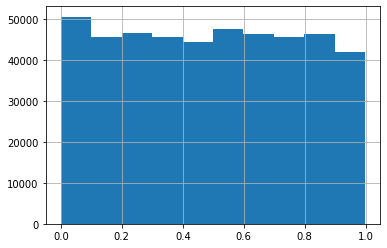

In [16]:
df["pct_rank"] = df["rank"] / df.groupby("id")["cell_id"].transform("count")

df["pct_rank"].hist(bins=10)

Doesn't look it!

Train-Valid Split

Since we want the entire notebook to be in either train or test split (or validation), we can use GroupShuffleSplit, using ancestor_id as per the data documentation

In [17]:
from sklearn.model_selection import GroupShuffleSplit

NVALID = 0.1  # size of validation set

splitter = GroupShuffleSplit(n_splits=1, test_size=NVALID, random_state=0)

train_ind, val_ind = next(splitter.split(df, groups=df["ancestor_id"]))

train_df = df.loc[train_ind].reset_index(drop=True)
val_df = df.loc[val_ind].reset_index(drop=True)

In [18]:
val_df.head()

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id,pct_rank
0,0067f63ef7597b,51abc333,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...,0,eeff2950,NaN,0.0
1,0067f63ef7597b,bdbdacca,code,import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport chardet\n,1,eeff2950,NaN,0.076923
2,0067f63ef7597b,eab6d65d,code,"with open('../input/forest-fires-in-brazil/amazon.csv', 'rb') as rawdata:\n result = chardet.detect(rawdata.read(...",3,eeff2950,NaN,0.230769
3,0067f63ef7597b,30186ffb,code,"data_path = '../input/forest-fires-in-brazil/amazon.csv'\ndf = pd.read_csv(data_path,encoding = 'ISO-8859-1',parse_...",4,eeff2950,NaN,0.307692
4,0067f63ef7597b,9d6783b0,code,df.describe(),5,eeff2950,NaN,0.384615


In [19]:
val_df["cell_type"].value_counts()

code        30436
markdown    16318
Name: cell_type, dtype: int64

In [20]:
train_df_mark = train_df[train_df["cell_type"] == "markdown"].reset_index(drop=True)

val_df_mark = val_df[val_df["cell_type"] == "markdown"].reset_index(drop=True)

### Competition Metrics

In [21]:
from bisect import bisect


def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions


def kendall_tau(ground_truth, predictions):
    total_inversions = 0
    total_2max = 0  # twice the maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max

Test out the metrics on example

In [22]:
y_dummy = val_df.groupby('id')['cell_id'].apply(list)
kendall_tau(df_orders.loc[y_dummy.index], y_dummy)

0.4048507084665296

### Modelling

#### Download and Save Distil-BERT model

In [23]:
from transformers import DistilBertTokenizer, DistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

tokenizer.save_pretrained(BERT_PATH)
model.save_pretrained(BERT_PATH)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Modelling imports and globals

In [24]:
from tqdm import tqdm
import sys, os
from transformers import DistilBertModel, DistilBertTokenizer
import torch.nn.functional as F
import torch.nn as nn
import torch

MAX_LEN = 128

In [25]:
class MarkdownModel(nn.Module):
    def __init__(self):
        super(MarkdownModel, self).__init__()
        self.distill_bert = DistilBertModel.from_pretrained(BERT_PATH)
        self.top = nn.Linear(768, 1)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = self.top(x[:, 0, :])
        return x

In [26]:
from torch.utils.data import DataLoader, Dataset


class MarkdownDataset(Dataset):
    '''
    Child DataSet class updating __getitem__ of the df and 
    replacing it to return Token ids, attention masks and percent rank
    '''
    
    def __init__(self, df, max_len):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.tokenizer = DistilBertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)

    def __getitem__(self, index):
        '''
        So, when we say data[1], the MarkdownDataset will return 
        Token ids, attention masks and percent rank of the index 1
        '''
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row.source,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask, torch.FloatTensor([row.pct_rank])

    def __len__(self):
        return self.df.shape[0]

In [27]:
train_ds = MarkdownDataset(train_df_mark, max_len=MAX_LEN)
val_ds = MarkdownDataset(val_df_mark, max_len=MAX_LEN)

val_ds[0]

(tensor([  101,  4874,  1035,  8902,  2015,  1027,  1031,  8902,  2005,  8902,
          1999,  1040,  2546,  1012,  7753,  2065,  1040,  2546,  1031,  8902,
          1033,  1012, 26718, 18863,  1027,  1027,  1005,  4874,  1005,  1033,
          2659,  1035,  7185,  3012,  1035,  8902,  2015,  1027,  1031,  8902,
          2005,  8902,  1999,  1040,  2546,  2065,  1040,  2546,  1031,  8902,
          1033,  1012, 16634,  7413,  1006,  1007,  1026,  2184,  1033,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

Adjusted Learning Rate and Optimizer

In [28]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 5e-5
    elif epoch < 2:
        lr = 1e-3
    elif epoch < 5:
        lr = 1e-4
    else:
        lr = 1e-5

    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
    
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=3e-4, betas=(0.9, 0.999),
                                 eps=1e-08)
    return optimizer

Create batched data using DataLoader API

In [29]:
BS = 32
NW = 8

train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=NW,
                          pin_memory=False, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BS, shuffle=False, num_workers=NW,
                          pin_memory=False, drop_last=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Define the training loop

In [35]:
def read_data(data):
    '''
    read features and labels
    '''
    return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()


def validate(model, val_loader):
    model.eval()
    
    tbar = tqdm(val_loader, file=sys.stdout)
    
    preds = []
    labels = []

    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            pred = model(inputs[0], inputs[1])

            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
    
    return np.concatenate(labels), np.concatenate(preds)

def train(model, train_loader, val_loader, epochs):
    np.random.seed(0)
    # Initialize optimizer
    optimizer = get_optimizer(model)
    # Initialize metric
    criterion = torch.nn.MSELoss()
    
    for e in range(epochs):
        # Start the training loop   
        model.train()
        tbar = tqdm(train_loader, file=sys.stdout)
        
        # Adjusted Learning Rate
        lr = adjust_lr(optimizer, e)
        
        loss_list = []
        preds = []
        labels = []

        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            # Recycle gradients
            optimizer.zero_grad()
            # Get model outputs
            pred = model(inputs[0], inputs[1])
            # Calculate loss
            loss = criterion(pred, target)
            loss.backward()
            # Complete optimizer step
            optimizer.step()
            
            # Append loss, predictions and labels
            loss_list.append(loss.detach().cpu().item())
            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())
            
            # Get average loss for the training loop
            avg_loss = np.round(np.mean(loss_list), 4)

            tbar.set_description(f"Epoch {e+1} Loss: {avg_loss} lr: {lr}")
            
        y_val, y_pred = validate(model, val_loader)
            
        print("Validation MSE:", np.round(mean_squared_error(y_val, y_pred), 4))
        print()
    return model, y_pred

model = MarkdownModel()
model = model.cuda()
model, y_pred = train(model, train_loader, val_loader, epochs=1)

  0%|          | 0/4405 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 510/510 [01:07<00:00,  7.57it/s]
Validation MSE: 0.0532

